In [1]:
import pandas as pd
import numpy as np

import time
import random
import re
import math
import collections
from collections import defaultdict

In [2]:
def shingle(text, k, remove_blank = False):
    #remove blank, like whitespace, /n...
    if remove_blank:
        pattern = re.compile(r'\s+')
        text = re.sub(pattern, '', text)
    
    sub_text = [text[i: i + k] for i in range(len(text) - k + 1)]

    #set to remove duplicate
    hash_value = set()
    for element in sub_text:
        hash_value.add(hash(element))
    
    return hash_value

In [3]:
def compare_set(set_1, set_2):
    return len(set_1 & set_2)/len(set_1 | set_2)

In [4]:
def minhash(k, lists):
    '''
    k stands for k independent hash function
    lists stands for input list, which is the output shingle function
    lists contains the shingle output for n docs
    '''
    res_dict = defaultdict(list)
    #np.random.seed(0)

    for i in range(k):
        
        a = np.random.randint(1, 10 ** 4)
        b = np.random.randint(1, 10 ** 4)
        
        for idx in range(len(lists)):
            res = float('inf')
            for element in lists[idx]:
                hash_value = (a * element - b) % (2 ** 32 - 1)
                if hash_value < res:
                    res = hash_value
            res_dict[idx].append(res)
            
    return res_dict

In [5]:
def CompareSignatures(sig1, sig2):
    '''
    sig1 stands for input signature 1
    sig2 stands for input signature 2
    signature is the output of minhash
    '''
    count = 0
    k = len(sig1)
    for i in range(k):
        if sig1[i] == sig2[i]:
            count += 1
    return count/k

In [6]:
def LSH(signatues, b):
    '''
    signatues is a dataframe, row stands for number of signatures in each doc, columns is number of docs
    b stands for b band
    '''
    #First step is to find the candidate
    cnt = 0
    signature_split = np.array_split(signatues, b)
    num_docs = signatues.shape[1]
    candidates = []
    rows = signatues.shape[0]/b
    threshold = np.power(1/b, 1/rows)
    start_time = time.time()

    #This is to hash each band of each docs
    for band in range(b):
        bucket_doc = dict()
        for doc in range(num_docs):
            sig_set = signature_split[band].iloc[:, doc]
            bucket_doc[doc] = hash(tuple(sig_set.values))
        
        # This is to find similar candidate for each band
        for i in range(num_docs):
            for j in range(i + 1, num_docs):
                if bucket_doc[i] == bucket_doc[j]:
                    candidates.append([i, j])

    # Here is to find the similarity of candidate, to see if it is greater than the threshold
    used_candidates = []
    for candidate in candidates:
        if candidate in used_candidates:
            continue
        used_candidates.append(candidate)
        sim = CompareSignatures(signatues.iloc[:, candidate[0]], signatues.iloc[:, candidate[1]])
        if sim > threshold:
            #print(f'doc{candidate[0]} and doc{candidate[1]} are similar, the similarity is {sim}')
            cnt += 1
    
    print(f'{cnt} similar item pairs found by LSH')
    print(f'time with LHS is {time.time() - start_time}')
    return threshold, candidates


In [7]:
#test
num = 100 # num stands for how many text we will use in this dataset

txt = pd.read_csv('articles1.csv')
tmp_txt = txt['content'].iloc[:num] #extract first num columns

hash_list = []
for i in range(num):
    hash_list.append(shingle(tmp_txt[i], 3))

#calculate jaccard similarity
jac_sim = np.zeros((num, num))
for i in range(num):
    for j in range(num):
        jac_sim[i][j] = compare_set(hash_list[i], hash_list[j])

# Apply minhashing to estimate jaccard similarity
start_time = time.time()
k = 100
minhash_jac_sim = np.zeros((num, num))
res_dict = minhash(k, hash_list)

for row in range(num):
    for col in range(num):
        minhash_jac_sim[row][col] = CompareSignatures(res_dict[row], res_dict[col])
print(f'time without LHS is {time.time() - start_time}')

# Apply LSH
minhash_list = [res_dict[i] for i in range(len(res_dict))]
LSH_input = pd.DataFrame(minhash_list).T

threshold, candidates = LSH(LSH_input, 25)

time without LHS is 6.2752366065979
936 similar item pairs found by LSH
time with LHS is 1.2606735229492188


In [8]:
cnt_minhash = 0
cnt_jac = 0
for row in range(num):
    for col in range(num):
        if minhash_jac_sim[row][col] > threshold:
            cnt_minhash += 1
        if jac_sim[row][col] > threshold:
            cnt_jac += 1
print(f'{(cnt_minhash - num)/2} similar item pairs found by minhash')

1222.0 similar item pairs found by minhash


In [9]:
threshold

0.4472135954999579

In [10]:
(cnt_jac - num)/2

83.0

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
num_docs = 30

# Read the data from csv file
df = pd.read_csv('articles1.csv')[:num_docs]
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [13]:
def shingle_document(document, k, HASH = True):
    
    shingles = set()
    for i in range(len(document) - k + 1):
        shingles.add(document[i:i+k])

    if HASH:
        return set([hash(shingle) for shingle in shingles])
    
    return shingles

# Create shingles of size 10
df['shingles'] = df['content'].apply(lambda x: shingle_document(x, 3, HASH = False))
df['hashed-shingles'] = df['content'].apply(lambda x: shingle_document(x, 3, HASH = True))

In [14]:
# Jaccard similarity of hashed shingles
def jaccard_similarity(shingles1, shingles2):
    return len(shingles1.intersection(shingles2)) / len(shingles1.union(shingles2))

print(jaccard_similarity(set(df['hashed-shingles'][0]), set(df['hashed-shingles'][1])))

0.34420096205237843


In [15]:
def func(a,b,x):
    return (a * x - b) % (2 ** 32 - 1)

# Minhashing function 
def minhashing(shingles, n):
    minhashes = []
    np.random.seed(0)

    for i in range(n):
        a = np.random.randint(1, 1e4)
        b = np.random.randint(1, 1e4)

        minhash = np.inf
        for shingle in shingles:
            minhash = min(minhash, func(a, b, shingle))
            #minhash = min(minhash, hash((i, shingle)))
            #minhash = min(minhash, hash(shingle))
        minhashes.append(minhash)
    return minhashes

# Create minhashes of size 100
df['minhashes'] = df['hashed-shingles'].apply(lambda x: minhashing(x, 100))

In [16]:
def CompareSignatures(signature1, signature2):
    count = 0
    for i in range(len(signature1)):
        if signature1[i] == signature2[i]:
            count += 1
    return count / len(signature1)

In [17]:

def LSH(minhashes, b):
    r = int(len(minhashes[0]) / b)
    print("r = ", len(minhashes[0]))
    t = np.power(1/b, 1/r)
    num_docs = len(minhashes)
    candidate_pairs = []

    #new code
    #buckets = {}

    for i in range(b):
        buckets = {}
        for j in range(num_docs):
            signature = minhashes[j]
            bucket = hash(tuple(signature[i * r:(i + 1) * r]))
            if bucket in buckets:
                buckets[bucket].append(j)
            else:
                buckets[bucket] = [j]

    #for i in range(len((buckets.values()))):
    #    if len(list(buckets.values())[i]) > 1:
    #        print(list(buckets.values())[i])

        for bucket in buckets:
            if len(buckets[bucket]) > 1:
                for doc1 in buckets[bucket]:
                    for doc2 in buckets[bucket]:
                        if doc1 < doc2:
                            if CompareSignatures(minhashes[doc1], minhashes[doc2]) > t:
                                candidate_pairs.append((doc1, doc2))

    return candidate_pairs,t

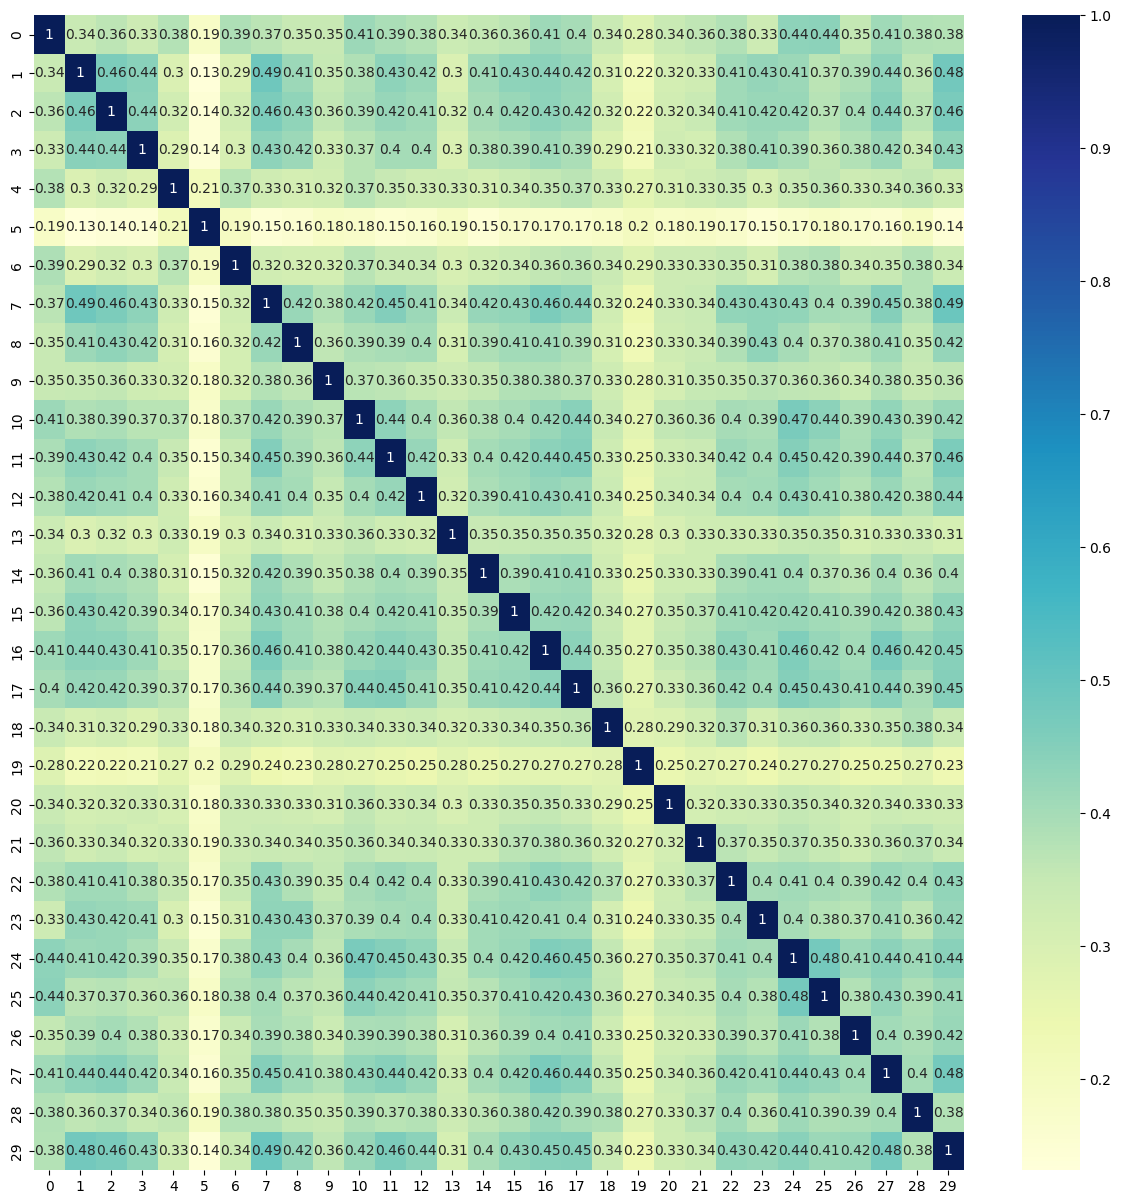

In [18]:
JaccardSim = np.zeros((num_docs, num_docs))
for i in range(num_docs):
    for j in range(num_docs):
        JaccardSim[i][j] = jaccard_similarity(set(df['hashed-shingles'][i]), set(df['hashed-shingles'][j]))

plt.figure(figsize=(15,15))
sns.heatmap(JaccardSim, cmap="YlGnBu", annot=True)
plt.show()

Time taken to compute minhashing similarity matrix:  3.2542576789855957


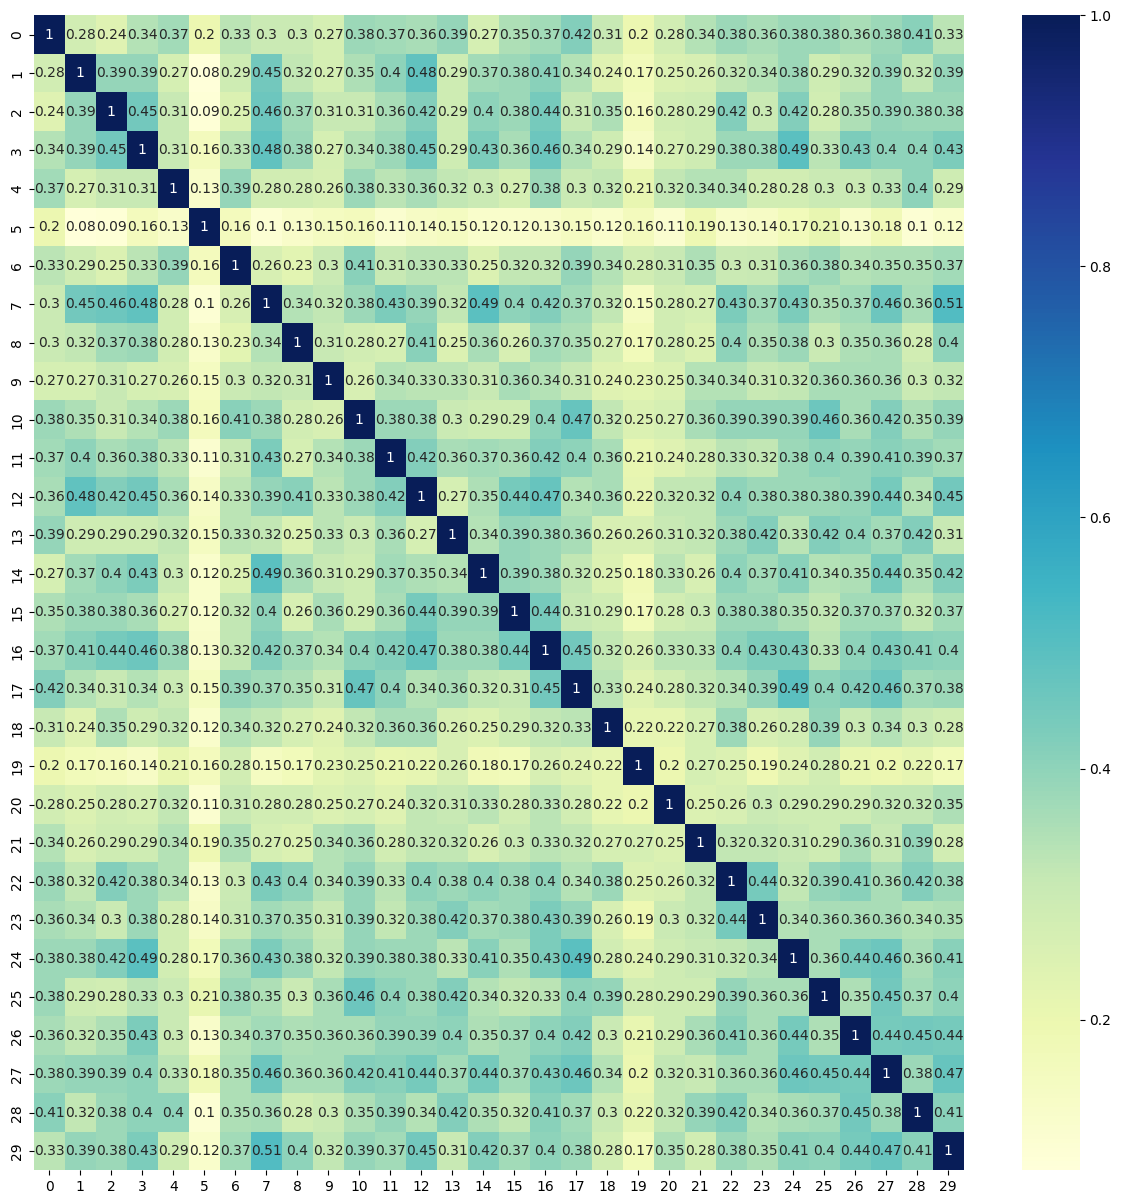

In [19]:
# calculate the minhashing similarity matrix
start_time = time.time()
minhashing_JaccardSim = np.zeros((num_docs, num_docs))
df['minhashes'] = df['hashed-shingles'].apply(lambda x: minhashing(x, 100))

for row in range(num_docs):
    for col in range(num_docs):
        minhashing_JaccardSim[row][col] = CompareSignatures(df['minhashes'][row], df['minhashes'][col])

comp_time = time.time() - start_time
print("Time taken to compute minhashing similarity matrix: ", comp_time)

plt.figure(figsize=(15,15))
sns.heatmap(minhashing_JaccardSim, cmap="YlGnBu", annot=True)
plt.show()



In [20]:
# Apply LSH to estimate similarity
start_time = time.time()
candidate_pairs, threshold = LSH(df['minhashes'], 25)
comp_time = time.time() - start_time
print("Time taken to compute LSH: ", comp_time)

# Pair with similarity greater than threshold
print("Threshold: ", threshold)
print("Number of pairs with similarity greater than threshold: ", len(set(candidate_pairs)))

r =  100
Time taken to compute LSH:  0.006978034973144531
Threshold:  0.4472135954999579
Number of pairs with similarity greater than threshold:  18


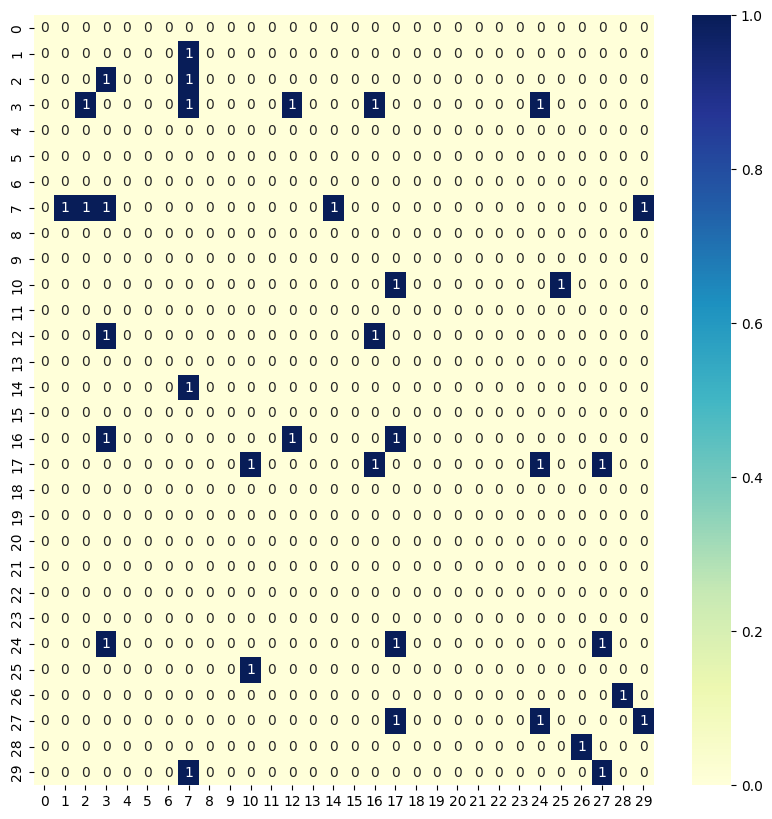

In [21]:
# heatmap matrix of LSH similarity matrix
LSH_sim = np.zeros((num_docs, num_docs))
for pair in candidate_pairs:
    LSH_sim[pair[0]][pair[1]] = 1
    LSH_sim[pair[1]][pair[0]] = 1

# plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(LSH_sim, cmap="YlGnBu", annot=True)
plt.show()

In [22]:
count = 0
count_minhash = 0
for i in range(num_docs):
    for j in range(num_docs):
        if minhashing_JaccardSim[i][j] > threshold:
            count_minhash += 1
        if JaccardSim[i][j] > threshold:
            count += 1

print("Number of pairs with similarity greater than threshold: ", (count-num_docs)/2)
print("Number of pairs with similarity greater than threshold: ", (count_minhash-num_docs)/2)

Number of pairs with similarity greater than threshold:  18.0
Number of pairs with similarity greater than threshold:  22.0
